In [33]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Load the pre-trained VGG16 model
vgg = keras.applications.VGG16(weights='imagenet',
                                include_top=False,
                                input_shape=(32, 32, 3)
                                )
#Freeze layers
for layer in vgg.layers[:10]:
    layer.trainable = False

last_layer = vgg.get_layer('block5_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Create a model using the pre-trained VGG16 as the base
m =    keras.layers.Flatten()(last_output)
m =    keras.layers.Dense(128, activation='relu')(m)
m =    keras.layers.Dense(10, activation='softmax')(m)
model=keras.models.Model(vgg.input,m)
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

last layer output shape:  (None, 1, 1, 512)


In [34]:
# Reshape the data from (28, 28) to (28, 28, 1)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Add padding to the images to make them 32x32
x_train = tf.image.resize(x_train, [32,32]) 
x_test = tf.image.resize(x_test, [32,32]) 

# Duplicate the grayscale channel to form a RGB image
x_train = np.concatenate([x_train, x_train, x_train], axis=-1)
x_test = np.concatenate([x_test, x_test, x_test], axis=-1)

# Update the shape of the data
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

In [35]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.9):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4,restore_best_weights=True)
history=model.fit(x_train, y_train,validation_data=(x_test, y_test), epochs=25,callbacks=[early_stopping])

Epoch 1/25
1875/1875 [==============================] - 30s 15ms/step - loss: 0.3268 - accuracy: 0.9049 - val_loss: 0.1563 - val_accuracy: 0.9500
Epoch 2/25
1875/1875 [==============================] - 28s 15ms/step - loss: 0.1445 - accuracy: 0.9548 - val_loss: 0.1283 - val_accuracy: 0.9571
Epoch 3/25
1875/1875 [==============================] - 27s 14ms/step - loss: 0.1178 - accuracy: 0.9629 - val_loss: 0.1186 - val_accuracy: 0.9608
Epoch 4/25
1875/1875 [==============================] - 28s 15ms/step - loss: 0.1042 - accuracy: 0.9652 - val_loss: 0.0958 - val_accuracy: 0.9686
Epoch 5/25
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0956 - accuracy: 0.9691 - val_loss: 0.0866 - val_accuracy: 0.9723
Epoch 6/25
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0878 - accuracy: 0.9722 - val_loss: 0.0924 - val_accuracy: 0.9713
Epoch 7/25
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0818 - accuracy: 0.9730 - val_loss: 0.0759 -

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

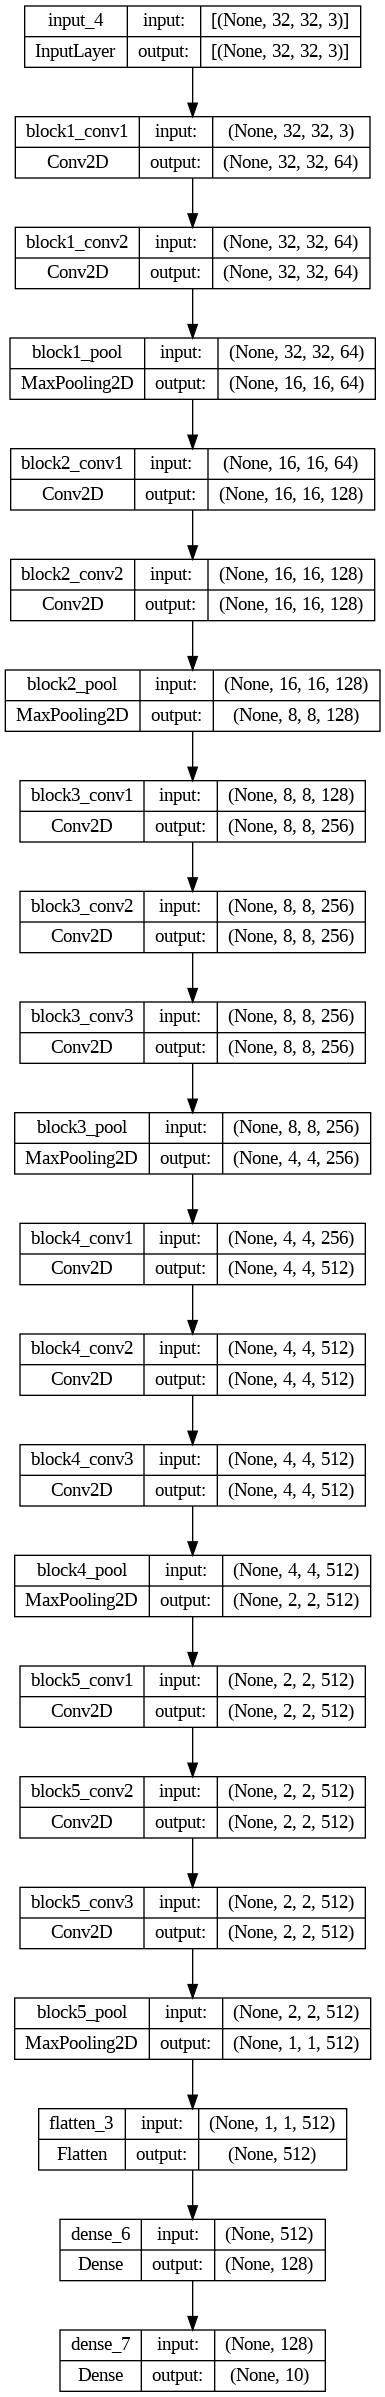

In [30]:
model.summary()
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

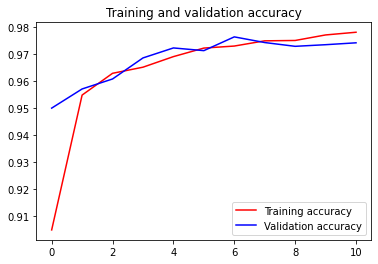

<Figure size 432x288 with 0 Axes>

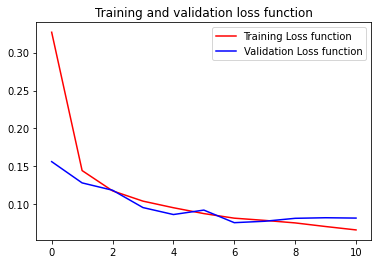

<Figure size 432x288 with 0 Axes>

In [36]:
import matplotlib.pyplot as plt
def summarize_diagnostics(history):
  acc = history.history['accuracy']
  loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(acc, 'r', label='Training accuracy')
  plt.plot(val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend(loc=0)
  plt.figure()
  plt.show()

  plt.plot(loss, 'r', label='Training Loss function')
  plt.plot(val_loss, 'b', label='Validation Loss function')
  plt.title('Training and validation loss function')
  plt.legend(loc=0)
  plt.figure()
  plt.show()
summarize_diagnostics(history)

1/1 [==============================] - 1s 592ms/step


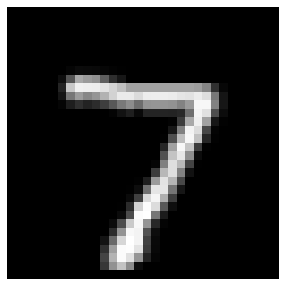

In [45]:
import matplotlib.pyplot as plt
x=x_test[0].reshape([1,32,32,3])
layer_outputs = []
for i, layer in enumerate(model.layers):
    if i in [1, 4, 7, 11,15,17]:
        layer_outputs.append(layer.output)
activation_model = keras.models.Model(inputs=model.input,outputs=layer_outputs)
fig = plt.figure(figsize=(5,5))
plt.imshow(x[0,:,:,0],cmap="gray")
plt.axis('off')
activations = activation_model.predict(x)

<ipython-input-46-112c47bb0b3f>:18: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


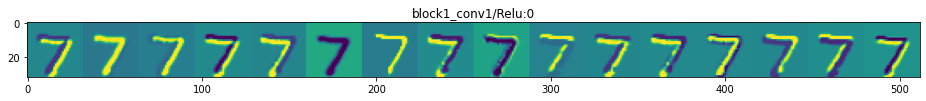

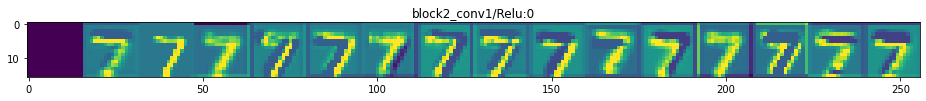

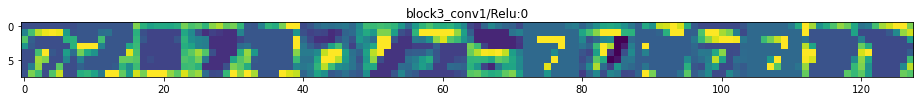

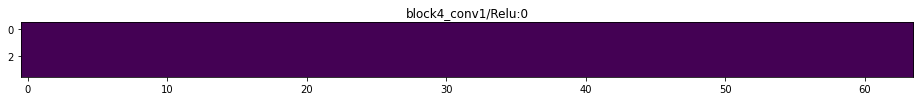

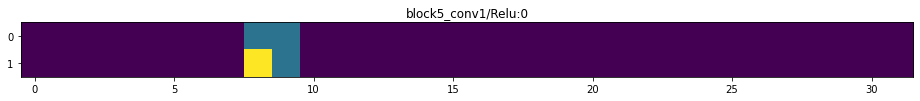

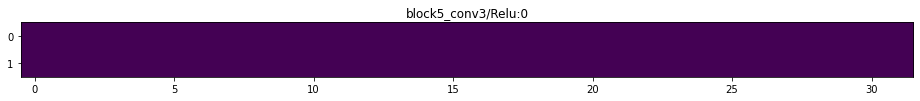

In [46]:
layer_names = []
for layer in layer_outputs[0:]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    n_features = min(n_features, 16) # Display only 16 feature maps per layer
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')